<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab04_feature_extaction/CepstralLiftering.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a> 
# Feature Extraction

This tutorial illustrates two mainstream feature extraction methods applied in speech recognition:   
i. Mel-spectrogram and   
ii. Mel Frequency Cepstral Features (MFCCs).
________________

In both cases the first step is a Fourier spectrogram computed using the sliding window approach with typically a shift of 10 msec.  The phase is discarded and only the log magnitude spectrum is maintained.   The further steps in the pipeline try to maintain the key content, but present it slightly different towards the recognition backend.

##### Note
The above statements need some clarification in the light of modern "end-to-end speech recognition systems".   These are trained to map the raw speech waveform to text.  However, they require huge amounts of data to be competitive.  Sometimes they start from a generic pretrained feature extraction such as 'wav2vec'.  Other high end systems use a mel spectrogram as input.  In our opinion it has only been shown that starting from the waveform is *possible* and not that it is *advantageous* over starting from a spectral representation.  And if not advantageous it must be concluded that starting from the waveform is computationally inefficient as it has been shown that the first layers in such deep neural net learn something very similar to a mel spectrogram.


#### From Spectrogram to Features

Starting from the log-magnitude spectrum we  apply additional FEATURE EXTRACTION.   The main purpose of this feature extraction is to help the pattern matching that will follow by:
- compacting the feature vector
- suppress disturbing, noisy side information at the same time
- transforming the feature vector to a domain better suited to the machine learning backend

This notebook shows how to do 2 prototypical feature extractions for speech recognition and the last part shows how alternative features can be added

1.  Mel Frequency Spectrum with splicing of multiple frames    
2.  Mel Frequency Cepstral Coefficients including Delta Features
3.  Alternative Features


In [1]:
# uncomment the pip install command to install pyspch -- it is required!
#
#!pip install git+https://github.com/compi1234/pyspch.git
#
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
%matplotlib inline
import os,sys, math, copy
import numpy as np
import librosa

import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd

import matplotlib.pyplot as plt
import matplotlib as mpl
import ipywidgets as widgets
from ipywidgets import interactive, VBox
from IPython.display import clear_output, display

mpl.rcParams['figure.figsize'] = [16.0, 9.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

### 0. Load a Waveform File and compute the Fourier Spectrogram
All feature extraction methods shown here have a Fourier Spectrogram as first step in the pipeline.

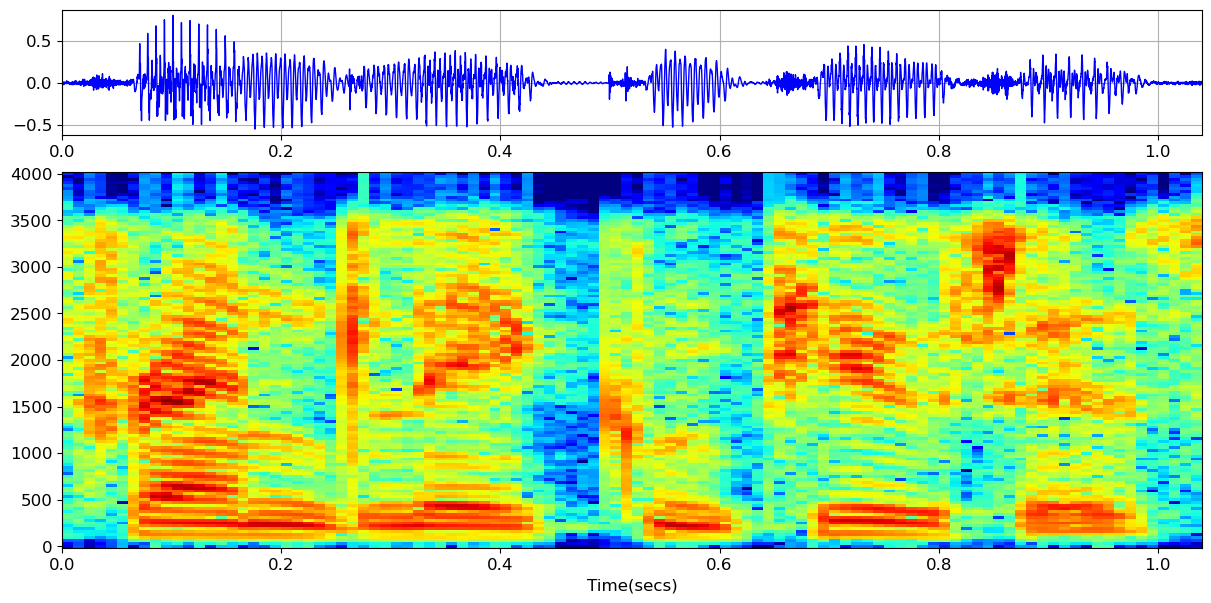

In [6]:
#name = 'demo/bad_bead_booed'
name = 'demo/friendly'
#
wavfname = name+".wav"
wavdata, sr = Spch.load_data(wavfname)
if sr > 16000:  wavdata, sr = Spch.load_data(wavfname,sample_rate=16000) 
segphn = Spch.load_data(name+ ".phn")
seggra = Spch.load_data(name+ ".gra")
seg = segphn if seggra is None else seggra

# compute a spectrogram with standard parameters as starting point for further analysis
shift=0.01
length=0.025
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift,f_length=length,n_mels=None,mode='dB')
(n_param,n_frames)=spg.shape
d_freq = sr/(2.*(n_param-1))
fig = Spd.PlotSpg(wavdata=wavdata,spgdata=spg,sample_rate=sr)
fig

### 3. MEL Spectrogram

When we use mel spectral features for speech recognition, it may not be simply the raw mel spectrogram that is fed to the recognizer.
Typically it will be a small pipeline consisting of  

___    
**Waveform &rarr; Fourier Spectrogram &rarr; Mel Spectrogam &rarr; Mean-Variance Normalization &rarr; Splicing and Stacking of frames**    
___    

**STEP 0. Fourier Spectrum**   
Defines the sliding window parameters

**STEP 1. Mel Spectrum**

First the Fourier Spectrum is converted to a mel Spectrum.  By this the frequency axis is warped as inspired by the human auditory system.  The warping corresponds roughly in maintaining the frequency spacing at low frequencies (below 1kHz) and doing a logarithmic compression on the frequency axis as higher frequencies (above 1kHz).  The high resolution mel spectrum (+- 80 channels) preserves both spectral envelope and pitch information in a single spectral representation.  Within *spchlab* we are by default using 80 channels for 16kHz sampling rate and 64 channels for 8kHz sampling rate.

If you want to use both 8kHz, 11.25kHz and 16kHz files in a single system, you can either upsample the waveform or resample the 16kHz mel filterbank so that it is useful at other sampling frequencies as well. 


**STEP 2. Mean / Variance Normalization**

In neural net and other machine learning systems it is common to *normalize* the feature vectors to zero mean and unit variance. This helps the machine learning backend as it scales features to an a priori defined range which helps in setting learning rates, etc.  Other motivations are valid as well.  Mean variance normalization obviously reduces session to session variability.  In (mel) spectrogram *mean normalization* is motivated as eliminating an arbitrary gain factor in the recording setup and has been common practice since long.


**STEP 3. Stacking of Frames**

From a spectral analysis point of view it makes sense to use short analysis windows (25msec) and frame shifts of 10msec.  However from a speech recognition point of view, it is better to observe the short time spectrum in its context.   This is simply achieved by stacking many adjacent vectors together.

We may e.g. stack $N$ frames on the left and the right using a stride of 2 as shown below.  This results in a receptive field of $2(N*s)+1$ frames wide.  Using a stride of 2 allows for a wider span receptive field while maintaining a manageble dimension of the feature vector.  
$$
\underbrace{ 
S_{i-N\times s} \hspace{8pt} \text{...} \hspace{8pt} S_{i-s} \hspace{8pt}  S_i \hspace{8pt} S_{i+s} \hspace{8pt} \text{...} \hspace{8pt}S_{i+N\times s} }_{F_i}
$$


In the example below we stack 5 frames to left and right and use a stride of 2 resulting in a receptive field of 210 msec and a feature vector dimension of 880 (for 80 mel coefficients).  Before splicing the mel spectral features are mean and variance normalized.



In [7]:
n_mels = 80 if sr > 8200 else 64
shift = 0.01
stride = 1
step=1
N = 1
fargs = {'fontsize':14}
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
spgmel = Sps.spg2mel(spg,sample_rate=sr,n_mels=n_mels)
spgmel_n = Sps.mean_norm(spgmel,type="meanvar")
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[spgmel,spgmel_n,spgmel_n],segwav=seg,sample_rate=sr,figsize=(20,10))
fig.axes[1].set_title("SPECTROGRAM",**fargs)
fig.axes[2].set_title("MEL-SPG (%d channels)" % n_mels,**fargs)
fig.axes[2].set_ylabel("mel%d"%n_mels,**fargs)
fig.axes[3].set_title("MEL-SPG-MVN + splicing (%d frames, stride=%d, receptive field=%d msec)" % (N*2+1, stride, int((N*2*stride+1)*shift*1000)),**fargs)
fig.axes[3].set_ylabel("mel%d"%n_mels,**fargs)
fig.axes[4].set_title("Feature Vector as 2D patch",**fargs)
fig.axes[4].set_ylabel("mel%d x %d"%(n_mels,N),**fargs)
fig.axes[1].set_xticks([])
fig.axes[2].set_xticks([])
fig.axes[3].set_xticks([])
fig.axes[4].set_xticks([])
fig.axes[4].set_xlabel(None)


def highlight_frame(fig,frame=0,N=1,stride=1):    # the animation part
    highlights = []
    pos = frame*shift
    for iax in np.arange(1,len(fig.axes)-1):
        ax = fig.axes[iax]
        patch = ax.axvspan(pos,pos+shift, color='w',alpha=.2,ec='k',lw=3.)   
        highlights.append(patch)
    ax = fig.axes[len(fig.axes)-2]

    for i in np.arange(-N,N):
        for j in np.arange(0,stride-1):
            ii = i*stride+j+1
            patch = ax.axvspan(pos+ii*shift,pos+(ii+1)*shift, color='grey', alpha=.7 ,ec=None)   
            highlights.append(patch)
    patch = ax.axvspan(pos-N*stride*shift,pos+(N*stride+1)*shift,fill=False,ec='k',lw=3.)  
    highlights.append(patch)
    fig.axes[3].set_title("MEL-SPG-MVN + splicing (%d frames, stride=%d, receptive field=%d msec)" % (N*2+1, stride, int((N*2*stride+1)*shift*1000)),**fargs)
    feature_vector = spgmel_n[:,(frame-N*stride):(frame+N*stride+1):stride]
    fig.add_img_plot(0*spgmel_n,iax=4,x0=0,dx=1)
    fig.add_img_plot(feature_vector,iax=4,x0=(frame-N),dx=1)
    fig.axes[4].set_ylabel("mel%d x %d"%(n_mels,2*N+1),**fargs)
    return(highlights)
    #filename = "animations/slwin_"+name+"_"

# Plot Melspectrogram while highlighting a specific frame
def plot_mspec_highlights(frame=0,N=1,stride=1):
    clear_output(wait=True)
    x=highlight_frame(fig,frame=frame,N=N,stride=stride)
    display(fig)
    for a in x: a.remove()

# run the main routine for the center frame
#plot_mspec_highlights(frame=spg.shape[1]//2,N=5,stride=2)

In [8]:
# RUN the above interactively
wg_instructions = widgets.HTML(
    "<b>FEATURE EXTRACTION: WIDENING THE RECEPTIVE FIELD using FRAME STACKING</b><br> \
    <b>frame</b> is  a frame slider<br>\
    <b>N</b> is the number of frames that should be added to the central frame both on <em>left</em> and <em>right</em> side<br>\
    <b>stride</b> is the number of frames that stacked frames are apart from each other <br><hr>")
iwgt = interactive(plot_mspec_highlights,frame=widgets.IntSlider(min=5,max=n_frames-5,value=n_frames/2,step=step),
                     N=widgets.IntSlider(min=0,max=10,value=5),stride=widgets.IntSlider(min=1,max=5,value=2),
            description='frame',layout=widgets.Layout(width='4in'));
VBox([wg_instructions,iwgt])

### 3. Mel Frequency Cepstral Coefficients (MFCCs)

MFCCs were the feature vector of choice with HMM/GMM systems.  They are still used in all kinds of situtations where training data is not abundant, thx to their compactness and decorrelation properties.   In modern DNN systems trained on thousands of hours of data, these mathematical properties become highly irrelevant and MFCCs have been replaced by the raw melspectrum or even the raw waveform.
___    
**Waveform &rarr; Fourier Spectrum &rarr; Mel Spectrum &rarr; Mel Cepstrum &rarr; Add Delta Features**    
___    

**STEP 0. Fourier Spectrum**   
Defines the sliding window parameters

**STEP 1. Mel Spectrum**   
A low resolution mel spectrum is adequate in the MFCC pipeline.   It is common to use 20 channels for narrowband signals (8kHz sampling rate) and 24 channels for wideband signals.

**STEP 2. Mel Cepstrum**   
The mel cepstrum is computed as the IDCT (inverse discrete cosine transform) of the mel spectrum.  Typically it is further truncated to 13 coefficients.
By virtue of the IDCT the cepstrum contains the same information as the spectrum.   However, the "truncated" cepstrum corresponds to the spectral envelope and suppresses the pitch.
It has been shown that the cepstral coefficients are highly decorrelated one vs. the other making them suitable for metrics like the Euclidean distance and which makes statistical model much simpler.  

**STEP 3. Delta's and Delta-Delta's**
In order to increase the receptive field one could simply splice a few frames of cepstra together.  This would, however, reintroduce correlation between successive frames.
A beter option is to include so called "Delta"-features that compute the "trend" over time (first order derivatives) and possibly also double delta's computed a second order derivative.  In practice the derivatives are approximated by simple regression formulas.

$$
\begin{align}
\Delta c_i  &= 2 c_{i+2} + c_{i+1} - c_{i-1} - 2 c_{i-2}  \\
\Delta\Delta c_i &=  \Delta c_{i+1} - \Delta c_{i-1}   
\end{align}
$$

The final feature vector is obtained by stacking instantaneous cepstral features with their delta's and delta-delta's.  Thus resulting in a 39-dimensional feature vector derived from a receptive field of 7 frames.

MFCCs are both compact and highly uncorrelated features.  This makes them suitable in almost all circumstances and for all backends.   Their main drawback is that the lossiness of the transform and the limited receptive field. 

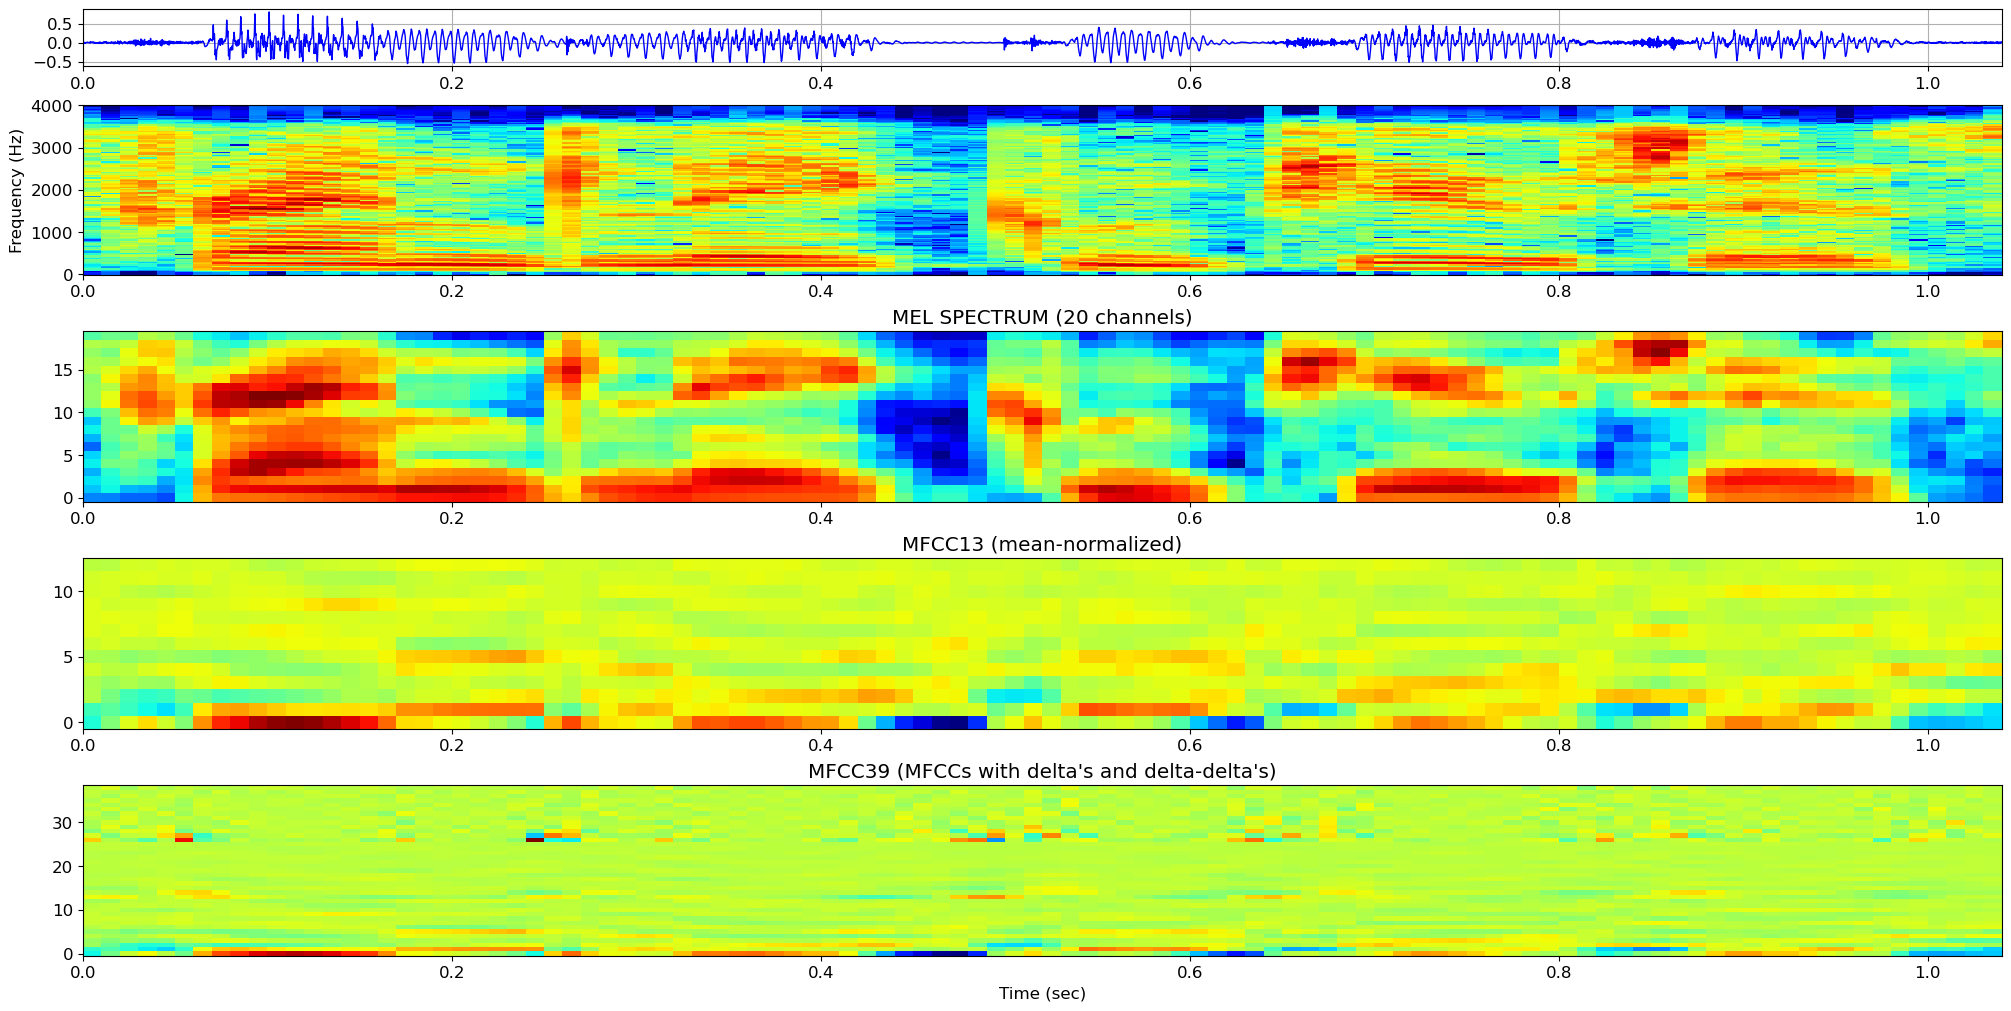

In [13]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
n_mels = 20 if sr == 8000 else 24
spgmel = Sps.spg2mel(spg,sample_rate=sr,n_mels=n_mels)
mfcc13 = Sps.cepstrum(S=spgmel,n_cep=13)
mfcc13_n = Sps.mean_norm(mfcc13)
mfcc39 = Sps.deltas(mfcc13_n,type="delta_delta2",Augment=True)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[spgmel,mfcc13_n,mfcc39],sample_rate=sr,figsize=(20,10))
fig.axes[2].set_title("MEL SPECTRUM (%d channels)" % n_mels)
fig.axes[3].set_title("MFCC13 (mean-normalized)")
fig.axes[4].set_title("MFCC39 (MFCCs with delta's and delta-delta's)")
display(fig)

### 3. Some Alternatives
In the following you can see a multitude of spectral and pitch alternatives that could be included in the feature extractions

In [11]:
# assumes a wavefile preloaded in *wavdata* and spectrogram precomputed in *spgdata*
#
def fe_plot(wavdata,sr,lifter=12,n_mels=80,mel_flag=False,view=['env'],ncol=1,iframe=None):
    shift = 0.01
    S = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
    #spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
    if mel_flag:
        cep = Sps.melcepstrum(S=S,n_cep=n_mels,n_mels=n_mels)
    else:
        cep = Sps.cepstrum(S=S)
    spg_env, spg_res =  Sps.cep_lifter(cep,n_lifter=lifter,n_spec=cep.shape[0])
    # we plot the mean normalized cepstrum for visual clarity
    cep_n = Sps.mean_norm(cep[1:,:])
    dy = sr/(2*(S.shape[0]-1))


    rms,pitch,zcr = Sps.time_dom3(y=wavdata,sr=sr, shift=.01, length=.03)

    #
    img_ftrs = []
    line_ftrs = []
    if 'cep' in view: img_ftrs.append(cep_n)
    if 'env' in view: img_ftrs.append(spg_env)
    if 'res' in view: img_ftrs.append(spg_res)
    if 'pitch' in view: line_ftrs.append(pitch)
    if 'pitch_period' in view: 
        pitch_period = np.ndarray(len(pitch))
        for i in range(0,len(pitch_period)):
            pitch_period[i] = 1000./pitch[i]
        line_ftrs.append(pitch_period)

    n_ftrs = len(img_ftrs)+len(line_ftrs)
    if ncol==1: col_widths=[1.]
    else: 
        col_widths = [3.,1.]
        if iframe is None: iframe = S.shape[1]//2
        elif iframe < 1 : iframe = 1
        
    fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=S,dy=dy,img_ftrs=img_ftrs,line_ftrs=line_ftrs,row_heights=([0.5,1]+[1]*n_ftrs),sample_rate=sr,figsize=(14,8),spglabel='Hz', col_widths=col_widths)

    ii=ncol
    fig.axes[ii].set_ylabel("Frequency(Hz)")
    fig.axes[ii].set_title("SPECTROGRAM")
    if iframe is not None:
        fig.add_vlines((iframe)*(shift),iax=0,color='k',lw=2)
        fig.add_vlines((iframe)*shift,iax=ii,color='k',lw=2)
    if ncol>1:
        sample_range = [int(sr*shift*(iframe-1)),int(sr*shift*(iframe+2))]
        # ??? not working
        fig.add_line_plot(wavdata[sample_range[0]:sample_range[1]],dx=1000./sr,iax=1,xlabel='msec')
        fig.add_line_plot(S[:,iframe],dx=dy,iax=3,xlabel='Hz')
    if 'cep' in view:
        ii+=ncol
        fig.axes[ii].set_title("CEPSTROGRAM")
        xlim = fig.axes[ii].get_xlim()
        fig.axes[ii].plot(xlim,[lifter,lifter],lw=3)
        if ncol>1:
            fig.add_vlines((iframe)*shift,iax=ii,color='k',lw=2)
            fig.add_line_plot(cep_n[:,iframe],iax=ii+1)
    if 'env' in view:
        ii+=ncol
        fig.axes[ii].set_title("ENVELOPE SPECTROGRAM")
        if ncol>1:
            fig.add_vlines((iframe)*shift,iax=ii,color='k',lw=2)
            fig.add_line_plot(spg_env[:,iframe],iax=ii+1,xlabel=' ')
    if 'res' in view:
        ii+=ncol
        fig.axes[ii].set_title("RESIDUE SPECTROGRAM")
        if ncol>1:
            fig.add_vlines((iframe)*shift,iax=ii,color='k',lw=2)
            fig.add_line_plot(spg_res[:,iframe],iax=ii+1,xlabel=' ')
    if ('pitch' in view) :
        ii+=ncol
        fig.axes[ii].set_title("PITCH")
        fig.axes[ii].set_ylabel("Frequency (Hz)")
    if ('pitch_period' in view):
        ii+=ncol
        fig.axes[ii].set_title("PITCH")
        fig.axes[ii].set_ylabel("Period (msec)")
    return(fig)



In [12]:
feature_selection = ['env','pitch_period']
ncol =2
n_mels=64

def fe_plot_int(iframe=1,lifter=10,mel=True,envelope=True,residue=True,pitch=True):
    feature_selection=[]
    
    fig = fe_plot(wavdata,sr,ncol=ncol, view=feature_selection, iframe=iframe,lifter=lifter,n_mels=n_mels,mel_flag=mel)
    display(fig)
    
wg_instructions = widgets.HTML(
    "<b>FEATURE EXTRACTION: MORE ALTERNATIVES for Spetral Representation</b><br> \
    <b>frame</b> is  a frame slider<br>\
    <b>N</b> is the number of frames that should be added to the central frame both on <em>left</em> and <em>right</em> side<br>\
    <b>stride</b> is the number of frames that stacked frames are apart from each other <br><hr>")

iwgt = interactive(fe_plot_int,iframe=widgets.IntSlider(min=2,max=n_frames-2,value=n_frames//2,step=step),
                  lifter=widgets.IntSlider(min=8,max=80,value=64),mel=widgets.Checkbox(value=True),
                  envelope=widgets.Checkbox(value=True),residue=widgets.Checkbox(value=True),pitch=widgets.Checkbox(value=True))

VBox([wg_instructions,iwgt])

In [9]:
####  INSTRUCTIONS


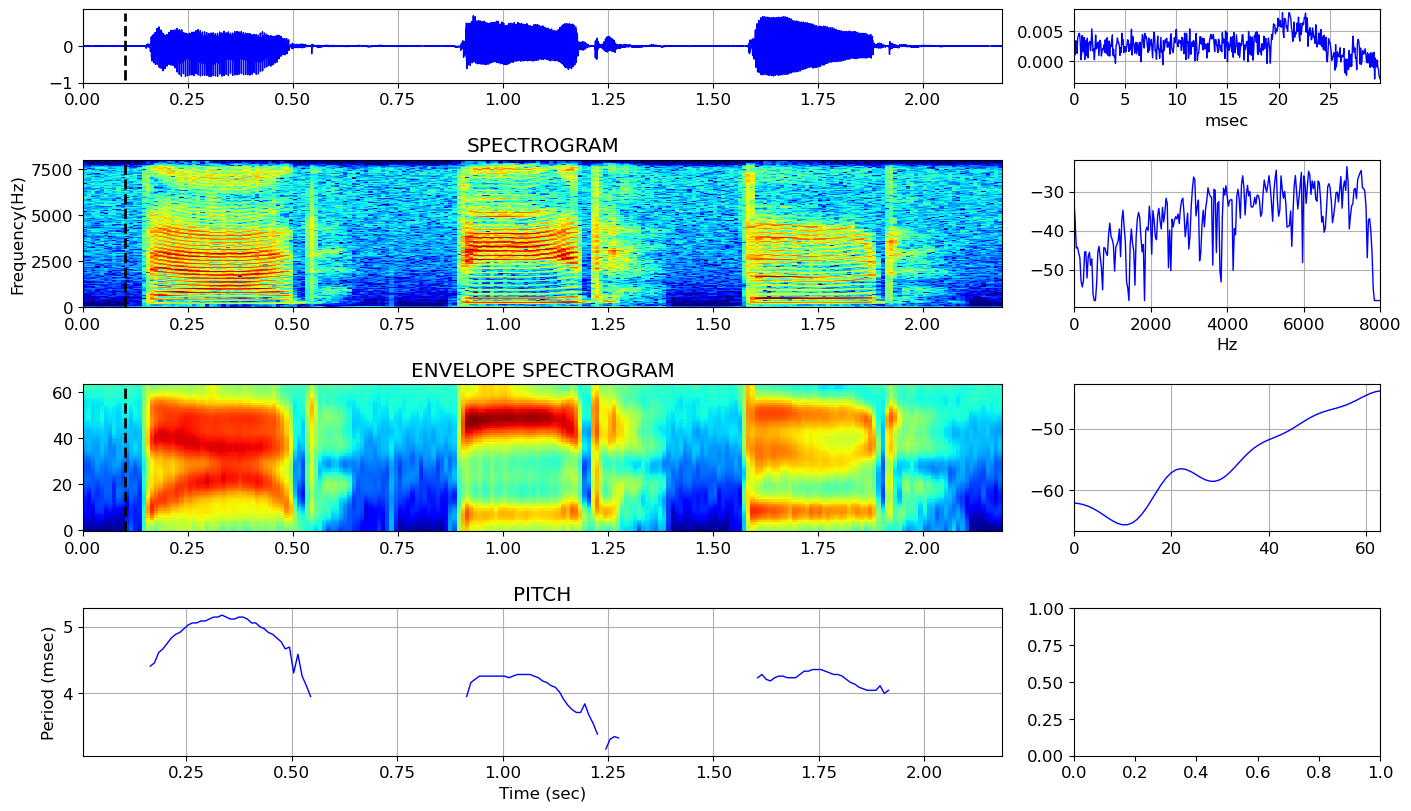

In [10]:
# options are 
feature_selection = ['env','pitch_period']
lifter = 10
mel_flag = True
frame = 10
ncol =2
fig = fe_plot(wavdata,sr,lifter=lifter,n_mels=n_mels,mel_flag=mel_flag,view=feature_selection,iframe=frame,ncol=ncol)
display(fig)